# Create OD volumes Using Generation and Distribution Steps

In [29]:
import os
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import pandas as pd

if manual:
    %matplotlib inline

In [30]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'

## Read Model

In [31]:
sm = stepmodel.read_zippedpickles(model_folder + '/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|██████████| 31/31 [00:01<00:00, 20.36it/s]        


# Generation
- Production = Population
- Attraction = Jobs

In [32]:
sm.zones['emission'] =  sm.zones['pop'].astype(int) / 10 # peak hour generation
sm.zones['attraction'] =  sm.zones['emp'].astype(int) / 10
sm.zones['pop'].sum()

2158238.2271273527

# Distribution
- Car owners (30% of population) distribution is proportional to car time
- PT captives (70% of population) distribution is proportional to PT time

## Car Owners

In [33]:
motor_rate = 0.3

In [34]:
car = sm.copy()
car.zones['emission'] *= motor_rate

# Impedence matrice = car time
imp_matrix = car.car_los[['origin', 'destination', 'time']].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)
car.step_distribution(deterrence_matrix = imp_matrix)

# PT Captives

In [35]:
pt = sm.copy()
pt.zones['emission'] *= (1 - motor_rate)

# Impedence matrice = PT time
imp_matrix = pt.pt_los[['origin', 'destination', 'gtime']].set_index(['origin','destination']).unstack() 
imp_matrix = imp_matrix.replace(0, 120)
pt.step_distribution(deterrence_matrix = imp_matrix)

## Merge volume matrices

In [36]:
sm.volumes = pd.merge(
    car.volumes,
    pt.volumes,
    on=['origin', 'destination'],
    suffixes=[ '_car_owner', '_pt_captive']
).rename(columns={'volume_car_owner': 'car_owner', 'volume_pt_captive': 'pt_captive'})
sm.volumes.head(5)

,origin,destination,car_owner,pt_captive
0,zone_0,zone_0,0.005188,0.007957
1,zone_0,zone_1,0.175681,0.459160
2,zone_0,zone_2,0.136994,0.291280
3,zone_0,zone_3,0.185262,0.425054
4,zone_0,zone_4,0.180202,0.386295


# Export

In [37]:
sm.to_zippedpickles(
    model_folder + '/{scen}/distribution'.format(scen=scenario), 
    only_attributes=['volumes', 'epsg', 'coordinates_unit']
)

volumes: 100%|██████████| 32/32 [00:00<00:00, 742.63it/s]


# Monitoring

In [38]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Car Owner Distribution')

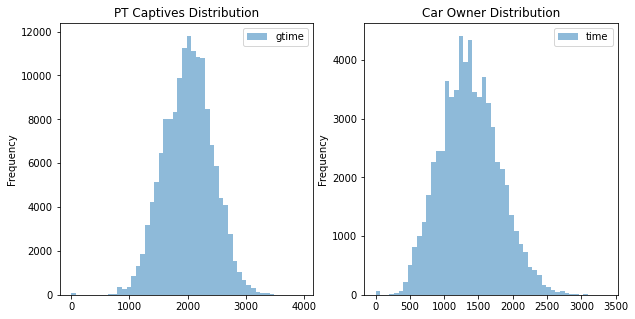

In [41]:
od = pd.merge(sm.volumes, sm.pt_los, on=['origin', 'destination'])
od = pd.merge(od, sm.car_los, on=['origin', 'destination'])
fig, axes = plt.subplots(1, 2, figsize=[10, 5])
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5, ax=axes[0])
plot.set_title('PT Captives Distribution')
plot = od[['time']].plot(kind='hist', weights=od['car_owner'], bins=50, alpha=0.5, ax=axes[1])
plot.set_title('Car Owner Distribution')

# END